In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import sampler
import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from PIL import Image

In [2]:
torch.cuda.set_device(0)
# specify dtype
use_cuda = torch.cuda.is_available()
if use_cuda:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
print(torch.cuda.device_count())
print(use_cuda)

1
True


In [3]:
# Hyperparameters
batch_size = 1
learning_rate = 4e-3
momentum = 0.9
num_epoch = 15

In [4]:
# Data
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

data_path = '/home/put_data/frank840925/IDP/data'
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

trainset = torchvision.datasets.CIFAR10(root=data_path, 
                                        train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                         num_workers=4)

valset = torchvision.datasets.CIFAR10(root=data_path, 
                                       train=False, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, sampler=ChunkSampler(5000,0),
                                       num_workers=4)

testset = torchvision.datasets.CIFAR10(root=data_path, 
                                       train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, sampler=ChunkSampler(5000,5000),
                                        num_workers=4)

print(trainset.__len__())
print(valset.__len__())
print(testset.__len__())

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
50000
10000
10000


In [5]:
# Helper functions
def plot_losses(loss_history1=None, loss_history2=None):
    plt.clf()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    if loss_history1:
        ax1.plot(loss_history1, color="blue", label="train")
    if loss_history2:
        ax1.plot(loss_history2, color="green", label="val")
    #ax2 = ax1.twinx()
    #ax2.set_yscale('log')
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Cross-entropy loss")
    #plt.savefig('output_losses.png')

def plot_accuracy(accuracy1=None, accuracy2=None):
    plt.clf()
    fig2 = plt.figure()
    ax1 = fig2.add_subplot(111)
    if accuracy1:
        ax1.plot(accuracy1, color="red", label="train")
    if accuracy2:
        ax1.plot(accuracy2, color="black", label="val")
    plt.xlabel("epoch") 
    plt.ylabel("accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Train/Val accuracy") 
    #plt.savefig('accuracy.png')

In [6]:
# self-defined modules(layers)
class Flatten(nn.Module):
    def forward(self, x):
        # read in N, C, H, W
        N, C, H, W = x.size()
        # flatten the C * H * W values into a single vector per image
        return x.view(N, -1)  
    
class idp_tensor(nn.Module):
    def __init__(self, idp):
        super(idp_tensor, self).__init__()
        self.idp = idp
    def forward(self, c):
        #input tensor c, size N*C*H*W, output with the same size, some channels zeroed according to idp
        N, C, H, W = c.size()
        non_zero_channel = int(C*(self.idp))
        zero_channels = C-non_zero_channel
        if zero_channels > 0:
            #zeros = Variable(torch.zeros(N, zero_channels, H, W)).type(dtype)
            zeros = Variable(torch.zeros(zero_channels).view(zero_channels,1)).type(dtype) #C
            zeros = zeros.expand(zero_channels, H) #C*H
            zeros = torch.stack([zeros]*W,1) #C*H*W
            zeros = torch.stack([zeros]*N) #N*C*H*W
            c = torch.cat([c[:, :non_zero_channel, :, :].clone(), zeros], 1).type(dtype)
            #c[:, non_zero_channel:, :, :] = zeros
            return c
        else:
            return c
        
class first_idp_tensor_3(nn.Module):
    def __init__(self, idp1=0.35, idp2=0.7, idp3=1):
        super(first_idp_tensor_3, self).__init__()
        self.idp1 = idp1
        self.idp2 = idp2
        self.idp3 = idp3
    def forward(self, c):
        #input the first conv-Relu-Linear output, N*C*H*W, replicate and apply idp and concat in first dim (N)
        N, C, H, W = c.size()
        non_zero_channel_1 = int(C*(self.idp1))
        non_zero_channel_2 = int(C*(self.idp2))
        non_zero_channel_3 = int(C*(self.idp3))
        if C-non_zero_channel_1 > 0:
            #zeros = Variable(torch.zeros(N, C-non_zero_channel_1, H, W)).type(dtype)
            zeros = Variable(torch.zeros(C-non_zero_channel_1).view(C-non_zero_channel_1,1)).type(dtype) #C
            zeros = zeros.expand(C-non_zero_channel_1, H) #C*H
            zeros = torch.stack([zeros]*W,1) #C*H*W
            zeros = torch.stack([zeros]*N) #N*C*H*W
            c1 = torch.cat([c[:, :non_zero_channel_1, :, :].clone(), zeros], 1).type(dtype)
        else:
            c1 = c
        if C-non_zero_channel_2 > 0:
            #zeros = Variable(torch.zeros(N, C-non_zero_channel_2, H, W)).type(dtype)
            zeros = Variable(torch.zeros(C-non_zero_channel_2).view(C-non_zero_channel_2,1)).type(dtype) #C
            zeros = zeros.expand(C-non_zero_channel_2, H) #C*H
            zeros = torch.stack([zeros]*W,1) #C*H*W
            zeros = torch.stack([zeros]*N) #N*C*H*W
            c2 = torch.cat([c[:, :non_zero_channel_2, :, :].clone(), zeros], 1).type(dtype)
        else:
            c2 = c
        if C-non_zero_channel_3 > 0:
            #zeros = Variable(torch.zeros(N, C-non_zero_channel_3, H, W)).type(dtype)
            zeros = Variable(torch.zeros(C-non_zero_channel_3).view(C-non_zero_channel_3,1)).type(dtype) #C
            zeros = zeros.expand(C-non_zero_channel_3, H) #C*H
            zeros = torch.stack([zeros]*W,1) #C*H*W
            zeros = torch.stack([zeros]*N) #N*C*H*W
            c3 = torch.cat([c[:, :non_zero_channel_3, :, :].clone(), zeros], 1).type(dtype)
        else:
            c3 = c
        out = torch.cat([c1, c2, c3], 0)
        return out
        
class middle_idp_tensor_3(nn.Module):
    def __init__(self, idp1=0.35, idp2=0.7, idp3=1):
        super(middle_idp_tensor_3, self).__init__()
        self.idp1 = idp1
        self.idp2 = idp2
        self.idp3 = idp3
    def forward(self, c):
        #input a middle conv-Relu-Linear output, (3*N)*C*H*W, apply IDP1, IDP2, IDP3 to each
        NN, C, H, W = c.size()
        if NN>=3:
            N = int(NN/3)
            non_zero_channel_1 = int(C*(self.idp1))
            non_zero_channel_2 = int(C*(self.idp2))
            non_zero_channel_3 = int(C*(self.idp3))
            c1 = c[:N,:,:,:]
            c2 = c[N:2*N,:,:,:]
            c3 = c[2*N:,:,:,:]
            if C-non_zero_channel_1 > 0:
                #zeros = Variable(torch.zeros(N, C-non_zero_channel_1, H, W)).type(dtype)
                zeros = Variable(torch.zeros(C-non_zero_channel_1).view(C-non_zero_channel_1,1)).type(dtype) #C
                zeros = zeros.expand(C-non_zero_channel_1, H) #C*H
                zeros = torch.stack([zeros]*W,1) #C*H*W
                zeros = torch.stack([zeros]*N) #N*C*H*W
                c1 = torch.cat([c1[:, :non_zero_channel_1, :, :].clone(), zeros], 1).type(dtype)
            else:
                c1 = c1
            if C-non_zero_channel_2 > 0:
                #zeros = Variable(torch.zeros(N, C-non_zero_channel_2, H, W)).type(dtype)
                zeros = Variable(torch.zeros(C-non_zero_channel_2).view(C-non_zero_channel_2,1)).type(dtype) #C
                zeros = zeros.expand(C-non_zero_channel_2, H) #C*H
                zeros = torch.stack([zeros]*W,1) #C*H*W
                zeros = torch.stack([zeros]*N) #N*C*H*W
                c2 = torch.cat([c2[:, :non_zero_channel_2, :, :].clone(), zeros], 1).type(dtype)
            else:
                c2 = c2
            if C-non_zero_channel_3 > 0:
                #zeros = Variable(torch.zeros(N, C-non_zero_channel_3, H, W)).type(dtype)
                zeros = Variable(torch.zeros(C-non_zero_channel_3).view(C-non_zero_channel_3,1)).type(dtype) #C
                zeros = zeros.expand(C-non_zero_channel_3, H) #C*H
                zeros = torch.stack([zeros]*W,1) #C*H*W
                zeros = torch.stack([zeros]*N) #N*C*H*W
                c3 = torch.cat([c3[:, :non_zero_channel_3, :, :].clone(), zeros], 1).type(dtype)
            else:
                c3 = c3
            out = torch.cat([c1, c2, c3],0)
            return out
        else:
            return c
        

class func_linear(nn.Module):
    def __init__(self, k=1):
        super(func_linear, self).__init__()
        self.k = k
    def channel_coeff(self, N, C, H, W):
        coeff_list = list(map(lambda a: 1-(a/(C+1)), range(0,C)))
        coeff_list = [[c] for c in coeff_list]
        coeff = Variable(torch.Tensor(coeff_list)).type(dtype) #C
        coeff_tensor = coeff.expand(C,H) #C*H
        coeff_tensor = torch.stack([coeff_tensor]*W,1) #C*H*W
        coeff_tensor = torch.stack(([coeff_tensor]*N)) #N*C*H*W
        return coeff_tensor

    def forward(self, x):
        N, C, H, W = x.size()
        x = torch.mul(x.clone(), self.channel_coeff(N, C, H, W))
        return x
        

In [7]:
class tesla_coef_idp_VGG_3branch_avg_pool(nn.Module):
    def __init__(self, idp_layers, model=models.vgg16(pretrained=True).type(dtype), idp1=0.35, idp2=0.7, idp3=1):
        #idp is 0~1, idp_layers is a set, specify which layer in features should apply idp
        #now idp_layers is 3,6,8,11,13,15,18,20,22,25,27,29
        super(tesla_coef_idp_VGG_3branch_avg_pool, self).__init__()
        self.idp1 = idp1
        self.idp2 = idp2
        self.idp3 = idp3
        self.idp_layers = idp_layers
        self.features = nn.Sequential(*(self.new_features_list(model)))
        self.classifier = nn.Sequential(nn.Linear(512, 512),
                              nn.ReLU(inplace=True),
                              nn.Dropout(0.5),
                              nn.Linear(512, 10))
    
    def new_features_list(self, model):
        new_layers = []
        #create from pre-trained resnet
        for i, layer in enumerate(list(model.features.children())):
            if i ==1:
                new_layers.append(layer)
                new_layers.append(func_linear())
                new_layers.append(first_idp_tensor_3(self.idp1, self.idp2, self.idp3))
            elif i not in self.idp_layers:
                if isinstance(layer, nn.MaxPool2d):
                    new_layers.append(nn.AvgPool2d(2, stride=2))
                else:
                    new_layers.append(layer)                
            else:
                new_layers.append(layer)
                new_layers.append(func_linear())
                new_layers.append(middle_idp_tensor_3(self.idp1, self.idp2, self.idp3))
        new_layers.append(Flatten())
        return new_layers        
    
    def forward(self, x):
        f = self.features(x)
        NN, M = f.size()
        N = int(NN/3)
        o1 = f[:N, :]
        o2 = f[N:2*N, :]
        o3 = f[2*N:,:]
        o1 = self.classifier(o1)
        o2 = self.classifier(o2)
        o3 = self.classifier(o3)
        return o1, o2, o3

In [10]:
img_mean = (0.485, 0.456, 0.406)
img_sd = (0.229, 0.224, 0.225)

In [13]:
idp_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
idp_layers = {3,6,8,11,13,15,18,20,22,25,27,29}
net_list = []
for i, t in enumerate(idp_test):
    net_list.append(tesla_coef_idp_VGG_3branch_avg_pool(idp_layers, idp1=1, idp2=1, idp3=t).type(dtype))

for n in net_list:
    n.load_state_dict(torch.load('saved_models/100_50_20_tesla_branch_linear_idp_avgpool.pkl'))

In [14]:
ideal_file_list = []
for file_index, data in enumerate(testloader):
    if file_index%500 == 0:
        print(file_index)
    images, labels = data
    labels = Variable(labels, volatile=True).type(torch.cuda.LongTensor)
    o10= net_list[0].forward(Variable(images, volatile=True).type(dtype))[2]
    p10 = torch.max(o10.data, 1)[1]
    o20= net_list[1].forward(Variable(images, volatile=True).type(dtype))[2]
    p20 = torch.max(o20.data, 1)[1]
    o30= net_list[2].forward(Variable(images, volatile=True).type(dtype))[2]
    p30 = torch.max(o30.data, 1)[1]
    o50= net_list[4].forward(Variable(images, volatile=True).type(dtype))[2]
    p50 = torch.max(o50.data, 1)[1]
    o60= net_list[5].forward(Variable(images, volatile=True).type(dtype))[2]
    p60 = torch.max(o60.data, 1)[1]
    o70= net_list[6].forward(Variable(images, volatile=True).type(dtype))[2]
    p70 = torch.max(o70.data, 1)[1]
    o80= net_list[7].forward(Variable(images, volatile=True).type(dtype))[2]
    p80 = torch.max(o80.data, 1)[1]
    o90= net_list[8].forward(Variable(images, volatile=True).type(dtype))[2]
    p90 = torch.max(o90.data, 1)[1]
    o100= net_list[9].forward(Variable(images, volatile=True).type(dtype))[2]
    p100 = torch.max(o100.data, 1)[1]
    if (torch.equal(p10,labels.data) is False and 
        torch.equal(p20,labels.data) and 
        torch.equal(p30,labels.data) is False and 
        torch.equal(p50,labels.data) and 
        torch.equal(p60,labels.data) and
        torch.equal(p70,labels.data) and
        torch.equal(p80,labels.data) and
        torch.equal(p90,labels.data) and
        torch.equal(p100,labels.data)):
        ideal_file_list.append(Variable(images, volatile=True).type(dtype))

0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [15]:
allcorrect_file_list = []
for file_index, data in enumerate(testloader):
    if file_index%500 == 0:
        print(file_index)
    images, labels = data
    labels = Variable(labels, volatile=True).type(torch.cuda.LongTensor)
    o10= net_list[0].forward(Variable(images, volatile=True).type(dtype))[2]
    p10 = torch.max(o10.data, 1)[1]
    o20= net_list[1].forward(Variable(images, volatile=True).type(dtype))[2]
    p20 = torch.max(o20.data, 1)[1]
    o30= net_list[2].forward(Variable(images, volatile=True).type(dtype))[2]
    p30 = torch.max(o30.data, 1)[1]
    o40= net_list[3].forward(Variable(images, volatile=True).type(dtype))[2]
    p40 = torch.max(o40.data, 1)[1]
    o50= net_list[4].forward(Variable(images, volatile=True).type(dtype))[2]
    p50 = torch.max(o50.data, 1)[1]
    o60= net_list[5].forward(Variable(images, volatile=True).type(dtype))[2]
    p60 = torch.max(o60.data, 1)[1]
    o70= net_list[6].forward(Variable(images, volatile=True).type(dtype))[2]
    p70 = torch.max(o70.data, 1)[1]
    o80= net_list[7].forward(Variable(images, volatile=True).type(dtype))[2]
    p80 = torch.max(o80.data, 1)[1]
    o90= net_list[8].forward(Variable(images, volatile=True).type(dtype))[2]
    p90 = torch.max(o90.data, 1)[1]
    o100= net_list[9].forward(Variable(images, volatile=True).type(dtype))[2]
    p100 = torch.max(o100.data, 1)[1]
    if (torch.equal(p10,labels.data) and 
        torch.equal(p20,labels.data) and 
        torch.equal(p30,labels.data) and 
        torch.equal(p40,labels.data) and
        torch.equal(p50,labels.data) and 
        torch.equal(p60,labels.data) and
        torch.equal(p70,labels.data) and
        torch.equal(p80,labels.data) and
        torch.equal(p90,labels.data) and
        torch.equal(p100,labels.data)):
        allcorrect_file_list.append(Variable(images, volatile=True).type(dtype))

0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [16]:
len(ideal_file_list)

502

In [17]:
len(allcorrect_file_list)

253

In [9]:
#save variable list
file_list = {}
file_list['ideal_file_list'] = ideal_file_list
file_list['allcorrect_file_list'] = allcorrect_file_list

import pickle

with open('visualize_file_list.pickle', 'wb') as handle:
    pickle.dump(file_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'ideal_file_list' is not defined

In [248]:
# hook the feature extractor
def hook_feature(net, x):
    features_blobs = []
    prev_feat = x
    for i, module in enumerate(list(net.features.children())):
        next_feat = module(prev_feat)
        features_blobs.append(next_feat.data.cpu().numpy())
        prev_feat = next_feat
    return features_blobs
# return CAM
def returnCAM(net, feature_conv, class_idx, idp=1):
    params = list(net.parameters())
    weight_softmax = np.squeeze(params[-4].cpu().data.numpy())
    # generate the class activation maps upsample to 32x32
    size_upsample = (32, 32)
    feature_conv = np.expand_dims(feature_conv[2,:,:,:], axis=0)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        #non_zero_channels = int(weight_softmax[idx].shape[0]*idp)
        #weight_softmax[idx][non_zero_channels:] = 0
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [256]:
#for all real, example idx:1, 14, 250
file_idx = 250
#img_variable = ideal_file_list[file_idx]
img_variable = allcorrect_file_list[file_idx]

nimg = img_variable.data.cpu().numpy().squeeze()
nimg = np.transpose(nimg, (1, 2, 0)) #w*H*C
nimg = (np.multiply(nimg, img_sd) + img_mean)*255
height, width, _ = nimg.shape

show_images = []
show_images.append(nimg/255)

for i, n in enumerate(net_list):
    logit = n(img_variable)[2]
    h_x = F.softmax(logit).data.squeeze()
    probs, idx = h_x.sort(0, True)
    features_blobs = hook_feature(n, img_variable)
    CAMs = returnCAM(n, features_blobs[39], [idx[0]], idp_test[i])
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + nimg * 0.5
    result_rgb = (result/255)[...,::-1]
    show_images.append(result_rgb)

In [260]:
#for 10 and 30 are false, example id: (280), 288, (289),(292), 285, 271, (294), (374), (376), 380
file_idx_list = [288, 285, 271, 380]
show_images = []

for file_idx in file_idx_list:
    img_variable = ideal_file_list[file_idx]
    nimg = img_variable.data.cpu().numpy().squeeze()
    nimg = np.transpose(nimg, (1, 2, 0)) #w*H*C
    nimg = (np.multiply(nimg, img_sd) + img_mean)*255
    height, width, _ = nimg.shape
    show_images.append(nimg/255)
    for i, n in enumerate(net_list):
        logit = n(img_variable)[2]
        h_x = F.softmax(logit).data.squeeze()
        probs, idx = h_x.sort(0, True)
        features_blobs = hook_feature(n, img_variable)
        CAMs = returnCAM(n, features_blobs[39], [idx[0]], idp_test[i])
        heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + nimg * 0.5
        result_rgb = (result/255)[...,::-1]
        show_images.append(result_rgb)

In [250]:
len(show_images)

11

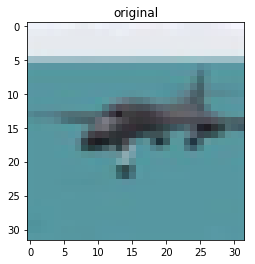

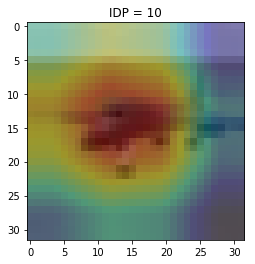

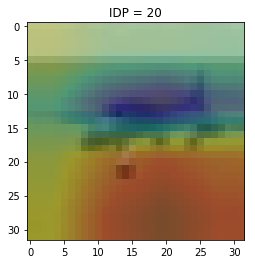

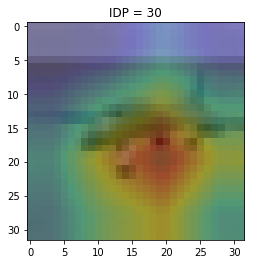

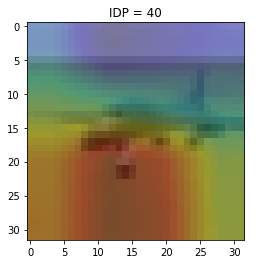

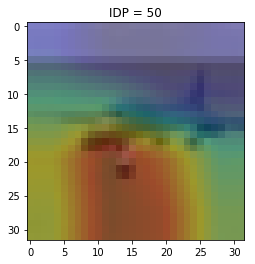

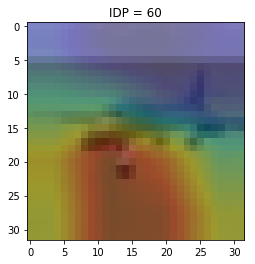

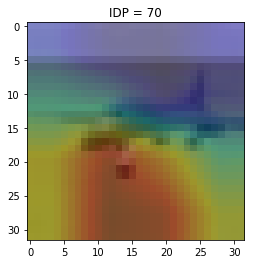

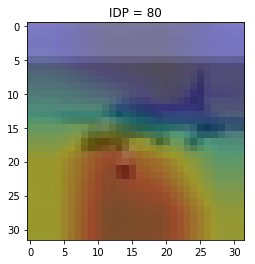

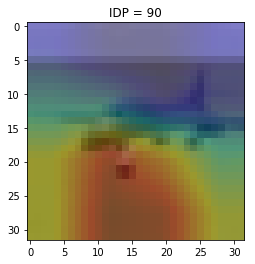

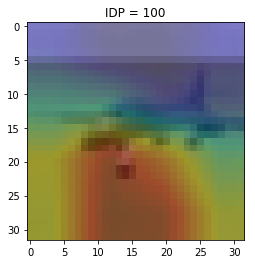

In [257]:
for i, ima in enumerate(show_images):
    plt.figure()
    if i<1:
        plt.title('original')
    else:
        string = 'IDP = '+str(10*i)
        plt.title(string)
    plt.imshow(ima)

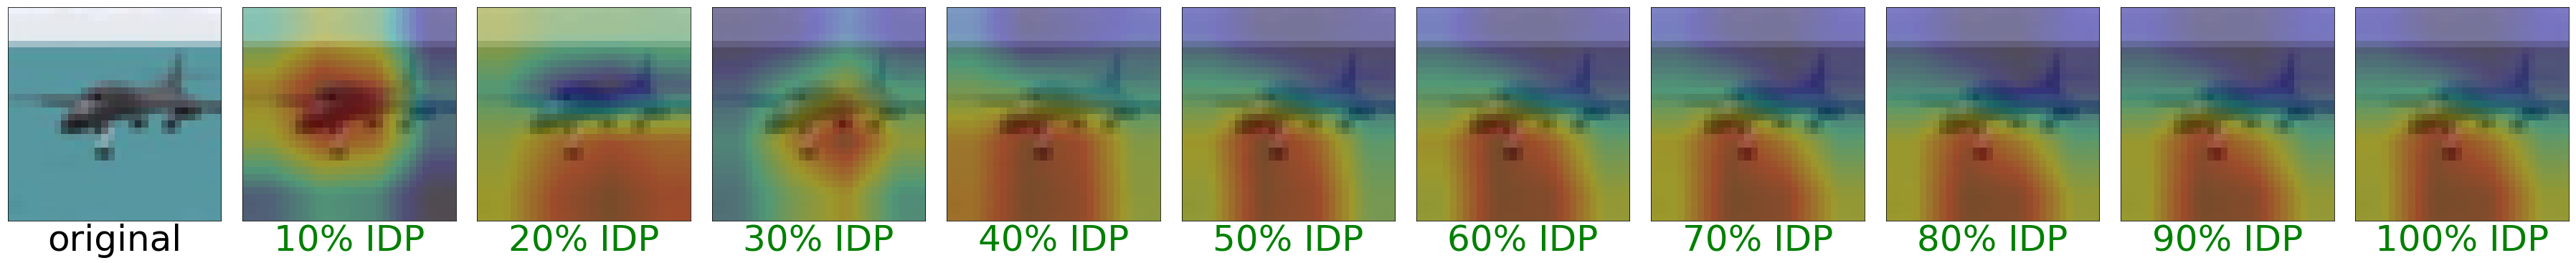

In [259]:
# all real examples 
plt.figure(figsize=(64,32))
columns = 11
for i, ima in enumerate(show_images):
    plt.subplot(len(show_images) / columns + 1, columns, i + 1)
    if i<1:
        plt.xlabel('original', fontsize=50)
    else:
        string = str(10*i) + '%' + ' IDP'
        plt.xlabel(string, color='g', fontsize=50)
    #plt.axis('off')
    plt.tick_params(axis="both", which='both', bottom='off',top='off',left='off',right='off',
                   labelbottom='off',labelleft='off')
    plt.imshow(ima)
plt.subplots_adjust(wspace=0.1)
plt.savefig('all_correct_figure7.eps', format='eps', dpi=100)

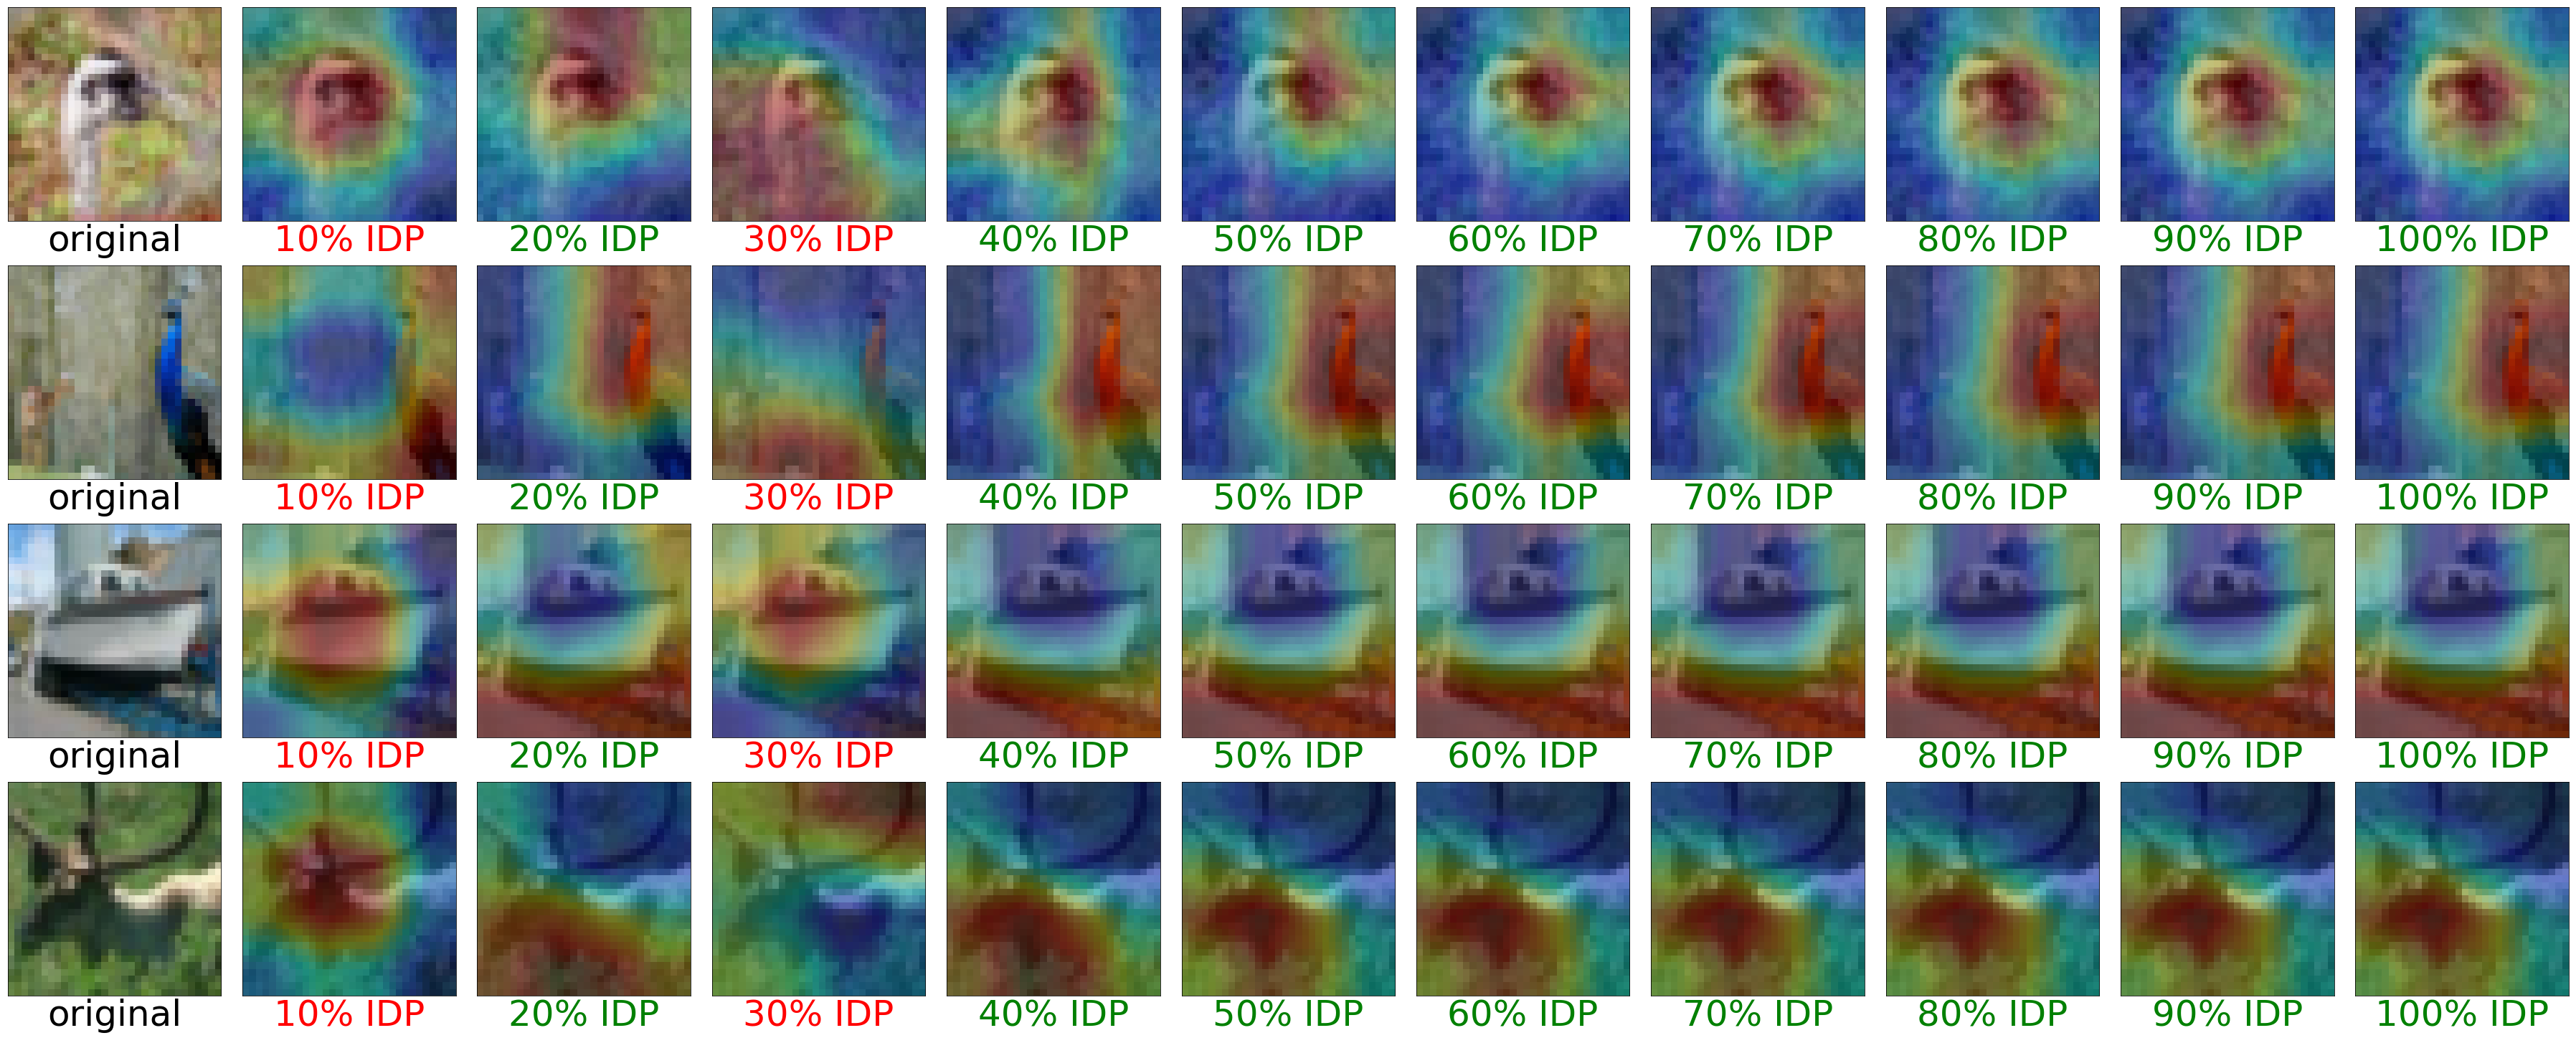

In [261]:
# 10 and 30 false examples
plt.figure(figsize=(64,32))
columns = 11

for i, ima in enumerate(show_images):
    plt.subplot(len(show_images) / columns + 1, columns, i + 1)
    #plt.axis('off')
    if i%11==0:
        plt.xlabel('original', fontsize=50)
    elif i%11 ==1 or i%11 ==3:
        string = str(10*(i%11))+'%'+' IDP'
        plt.xlabel(string, color='r', fontsize=50)
    else:
        string = str(10*(i%11))+'%'+' IDP'
        plt.xlabel(string, color='g', fontsize=50)
    plt.tick_params(axis="both", which='both', bottom='off',top='off',left='off',right='off',
                   labelbottom='off',labelleft='off')
    plt.imshow(ima)
    
plt.subplots_adjust(wspace=0.1)    
plt.savefig('CAM_all_example_figure2.eps', format='eps', dpi=100)

In [ ]:
#for i, f in enumerate(features_blobs):
#    print(i, f.shape)